<a href="https://colab.research.google.com/github/RoSchilling/Analise-NovaNexus/blob/main/Analise_Novexus_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importando pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import json
import seaborn as sns

# Retirando os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários Classificação
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Acessando os dados
# Url dos dados
url = 'https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json'

# Definindo a requisição dos dados
resposta = requests.get(url)

# Testando requisição
if resposta.status_code == 200:
  print("Informação recebida com sucesso")
else:
  print(f"Ocorreu um erro {resposta.status_code} com a requisição")

Informação recebida com sucesso


In [ ]:
# convertendo o Json
dados_json = resposta.json()

# Convertendo em data frame
df = pd.json_normalize(dados_json)

# Desconsiderando as chaves
df.columns = [col.split('.')[-1] for col in df.columns]


# Analise Exploratória dos dados

In [ ]:
# Verificando as linhas do dataframe de maneira aleatória
df.sample(n=5)

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
3082,4293-ETKAP,No,Female,0,Yes,Yes,65,Yes,Yes,DSL,...,Yes,No,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),79.40,5071.9
580,0829-DDVLK,No,Female,0,No,No,15,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),20.10,302.45
2711,3754-DXMRT,Yes,Male,1,No,No,2,Yes,No,DSL,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.15,92.65
2902,4020-KIUDI,No,Male,0,Yes,Yes,6,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.85,138.85
805,1137-DGOWI,No,Female,0,Yes,No,30,Yes,No,DSL,...,Yes,Yes,Yes,No,Yes,One year,No,Bank transfer (automatic),70.25,2198.9


In [ ]:
# Verificando as caracteristicas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


Nota que o DataFrame possui 20 colunas, sendo 18 do tipo object, uma do tipo float e duas do tipo inteiro. No total são 7267 lançamentos, não sendo encontrados dados nulos, contudo isso não significa a inexistência de valores não preenchido.

In [ ]:
# Analise descritiva dos dados númericos
df.describe()

,SeniorCitizen,tenure,Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


Nota-se que a coluna SeniorCitizen contém apenas valores em zero e um, sendo a sua maioria zero devido a média encontrada. Já a coluna correspondente aos meses dos contratos do cliente tem uma variação maior assim como a coluna Monthly. Correspondente ao número total de serviços do cliente por mês.

In [ ]:
# Verificando quantidade de dados únicos das colunas
for col in df.columns:
  qnt = len(df[col].unique())
  print(f'A coluna {col}, contém {qnt} dados únicos, sendo eles {df[col].unique()}')

A coluna customerID, contém 7267 dados únicos, sendo eles ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
A coluna Churn, contém 3 dados únicos, sendo eles ['No' 'Yes' '']
A coluna gender, contém 2 dados únicos, sendo eles ['Female' 'Male']
A coluna SeniorCitizen, contém 2 dados únicos, sendo eles [0 1]
A coluna Partner, contém 2 dados únicos, sendo eles ['Yes' 'No']
A coluna Dependents, contém 2 dados únicos, sendo eles ['Yes' 'No']
A coluna tenure, contém 73 dados únicos, sendo eles [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]
A coluna PhoneService, contém 2 dados únicos, sendo eles ['Yes' 'No']
A coluna MultipleLines, contém 3 dados únicos, sendo eles ['No' 'Yes' 'No phone service']
A coluna InternetService, contém 3 dados únicos, sendo eles ['DSL' 'Fiber optic' 'No']
A 

Para as colunas com mais de duas dummys será necessário aplicar a técnica de one-hot-encoding para padronizalas, enquanto para as colunas com 'Yes' or 'No' É possível utilizar apenas o dummy enconding. Nota-se que algumas colunas tem Uma resposta a mais que pode ser adicionado ao grupo de negação da variável.

# Tratamento dos dados

Primeiramente será alterado nas colunas que contém o valor 'No internet service' por 'No', pois os dois tem o mesmo significado para estes atributos.

In [ ]:
# Criando copia do df
data = df.copy()

# Alterando o valor 'No Internet service' e 'No phone service'
for col in data.columns:
  if data[col].dtype == 'object':  # Verifica se a coluna contém strings
        data[col] = data[col].str.replace('No phone service', 'No')
        data[col] = data[col].str.replace('No internet service', 'No')

# Verificando o dataframe após a alteração
for col in df.columns:
  qnt = len(df[col].unique())
  print(f'A coluna {col}, contém {qnt} dados únicos, sendo eles {df[col].unique()}')


A coluna customerID, contém 7267 dados únicos, sendo eles ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
A coluna Churn, contém 3 dados únicos, sendo eles ['No' 'Yes' '']
A coluna gender, contém 2 dados únicos, sendo eles ['Female' 'Male']
A coluna SeniorCitizen, contém 2 dados únicos, sendo eles [0 1]
A coluna Partner, contém 2 dados únicos, sendo eles ['Yes' 'No']
A coluna Dependents, contém 2 dados únicos, sendo eles ['Yes' 'No']
A coluna tenure, contém 73 dados únicos, sendo eles [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]
A coluna PhoneService, contém 2 dados únicos, sendo eles ['Yes' 'No']
A coluna MultipleLines, contém 3 dados únicos, sendo eles ['No' 'Yes' 'No phone service']
A coluna InternetService, contém 3 dados únicos, sendo eles ['DSL' 'Fiber optic' 'No']
A 

In [ ]:
# Verificando a quantidade de valores vazios no churn e a representação deles na população do dataset
qnt_vazio = data['Churn'][df['Churn'] == ''].count()
total_dados = data.count()[0]

print(f'São {qnt_vazio} dados vazio o conjunto tem um total de {total_dados}, isso representa um valor de {(qnt_vazio/total_dados):.2%}')

São 224 dados vazio o conjunto tem um total de 7267, isso representa um valor de 3.08%


Os dados vazios representam o total de 3.08% dos valores, será necessário avaliar as demais colunas com relação a esses dados para saber como trata-lo. Para esta analise será utilizado os valores antes das alterações.

In [ ]:
# Verificando os dados
df[df['Churn'] == ''].sample(n=5)

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
3438,4762-XTUEC,,Female,0,Yes,No,67,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),109.70,7344.45
3177,4438-GGYWL,,Male,0,Yes,Yes,62,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),115.55,7159.05
1805,2575-EAMDV,,Female,0,No,No,35,Yes,No,Fiber optic,...,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,99.25,3532
791,1119-VJAQV,,Male,1,Yes,No,6,Yes,Yes,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,80.80,457.1
932,1314-HQHAL,,Male,0,No,No,58,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.30,1131.5


Ao analisar a base é possível notar que alguns valores da coluna Churn apesar de ser vazio possuem, informações esses valores serão ignorados no momento inicial para após treino do modelo determinar os seus valores

In [ ]:
# Retirando os valores vazios da Churn do conjunto de dados
data = data.loc[~(data['Churn'] == '')]

# Alterando os valores vazio da coluna total pela média dos valores
data['Total'] = np.where(
    data['Total'] == ' ', data['Total'].loc[~(data['Total'] == ' ')].astype(float).mean(), data['Total']
)

# Alterando o tipo da coluna total
data['Total'] = data['Total'].astype(float)

# Retirando a coluna ID
data = data.drop('customerID', axis=1)


# Vizualização dos dados

Inicialmente é interessante demonstar como a distribuição das variáveis continuas se comporta no histograma.Para isso inicialmente iremos usar o pacote 'seaborn', contudo este pacote nos limita na hora da visualização, por não demonstrar de maneira dinâmica os valores plotados. Para transpor essa barreira após o gráfico abaixo será utilizado o 'plotly'

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'Monthly'}>],
       [<Axes: title={'center': 'Total'}>, <Axes: >]], dtype=object)

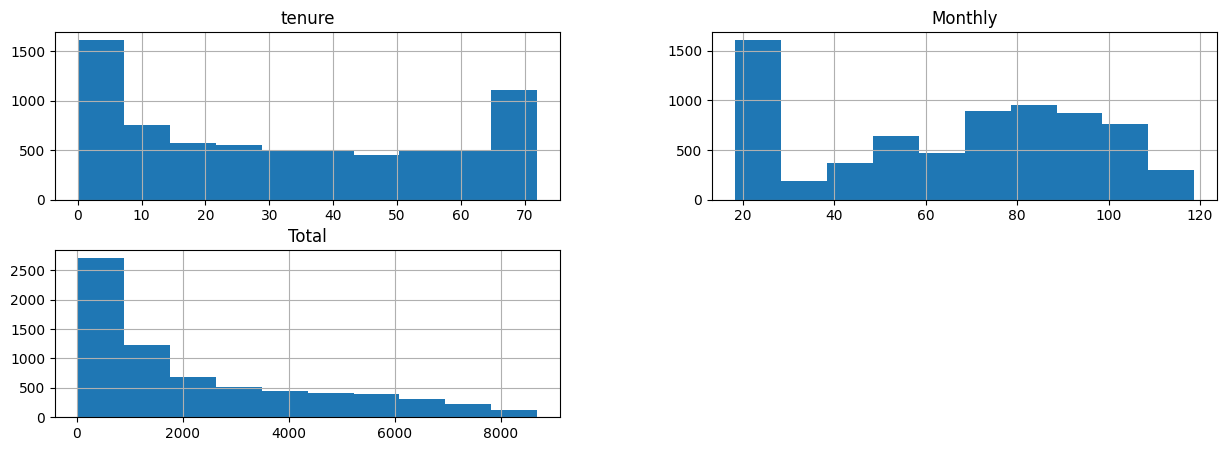

In [ ]:
# Verificando a distribuição de frequencia das variáveis númericas
# Retirada a coluna SeniorCitizen, pois ela contém apenas dois valores
data.drop('SeniorCitizen', axis=1).hist(figsize=(15,5))

In [ ]:
# definido função para os graficos
def graficos_barra(df, columns, values):
    #Calculando as quantidades
    quantidade = df.groupby([columns, 'Churn'])[values].count().reset_index()


    # criando a figura
    fig =px.bar(
        quantidade,
        x=columns,
        y=values,
        color='Churn'
    )

    return fig


In [ ]:
# Criando o gráfico de gênero
fig = graficos_barra(data, 'gender', 'Total')

fig.show()

Nota-se que na base de clientes o número de homens e mulheres é muito próximo, tendo um número pequeno de a mais de homens. Ao avaliar o número de Churn por sexo nota-se que não há muita diferença entre os sexos, com ambos ficando muito próximo

In [ ]:
# Criando o gráfico de InternetService
fig = graficos_barra(data, 'InternetService', 'Total')

fig.show()


In [ ]:
# Criando o gráfico de OnlineSecurity
fig = graficos_barra(data, 'OnlineSecurity', 'Total')

fig.show()

In [ ]:
# Criando o gráfico de DeviceProtection
fig = graficos_barra(data, 'DeviceProtection', 'Total')

fig.show()

In [ ]:
# Criando o gráfico de TechSupport
fig = graficos_barra(data, 'TechSupport', 'Total')

fig.show()

In [ ]:
# Criando o gráfico de Contract
fig = graficos_barra(data, 'Contract', 'Total')

fig.show()

In [ ]:
# Criando o gráfico de Contract
fig = graficos_barra(data, 'PaymentMethod', 'Total')

fig.show()

In [ ]:
# Criando o gráfico de Contract
fig = graficos_barra(data, 'SeniorCitizen', 'Total')

fig.show()

<Axes: >

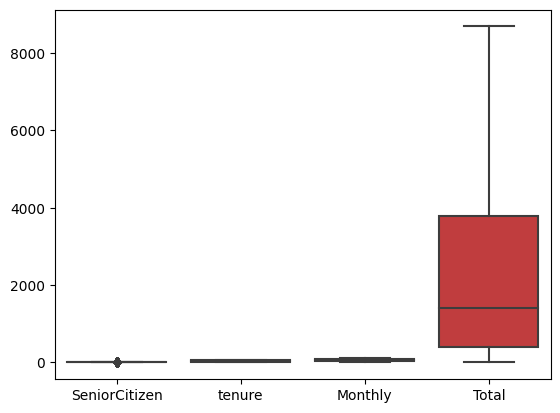

In [ ]:
sns.boxplot(data)

# Criação das variáveis dummy

In [ ]:
#Criando cópia do DataFrame para as novas alterações
df_premodel = data.copy()

# Separando as variáveis categoricas
col_categoricas = df_premodel.select_dtypes(include="object").columns

# Alterando os valores 'yes' para '1' e 'no' para '0'
for col in col_categoricas:
    if df_premodel[col].nunique() == 2:
        df_premodel[col] = np.where(data[col] == 'Yes', 1, 0)

In [ ]:
# Avaliando os dados após a alteração
df_premodel.sample(n=5)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
6739,1,0,0,1,1,13,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Credit card (automatic),74.40,896.75
5761,0,0,1,0,0,67,1,1,DSL,0,1,0,0,0,0,Month-to-month,0,Electronic check,54.90,3725.50
7003,0,0,0,1,1,53,1,0,DSL,0,0,1,0,0,1,One year,0,Credit card (automatic),60.60,3297.00
2407,0,0,0,1,1,71,1,1,Fiber optic,1,0,1,0,1,1,Two year,0,Electronic check,105.55,7405.50
3104,0,0,1,1,0,70,1,1,Fiber optic,0,1,0,1,1,1,One year,1,Bank transfer (automatic),105.55,7195.35


In [ ]:
# Aplicando o dummie encondig para as varíaveis categoricas
col_categoricas = df_premodel.select_dtypes(include='object').columns

df_model = pd.get_dummies(df_premodel, dtype=int)

df_model

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,1,9,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,9,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,4,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,1,0,1,1,0,13,1,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4,1,0,1,1,0,3,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0,0,0,0,0,13,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
7263,1,0,0,1,0,22,1,1,0,0,...,0,1,0,1,0,0,0,0,1,0
7264,0,0,0,0,0,2,1,0,0,1,...,1,0,0,1,0,0,0,0,0,1
7265,0,0,0,1,1,67,1,0,1,0,...,1,0,0,0,0,1,0,0,0,1


# Treinando o modelo

## Preparando os dados

In [ ]:
# Criando a variável explicativa
X = df_model.copy()
X = X.drop('Churn', axis=1)

# Ajustando a variável de saída
y = df_model['Churn']

# Separando os dados de treino e de teste, será utilizado 80% do dataset para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Criando os folds para validação cruzada
num_particoes = 10

# Realizando a partição em 10 folds
Kfold = KFold(n_splits= num_particoes, shuffle = True, random_state=7)

# Modelagem

## Base Line

KNN: 0.766074 (0.022946)
CART: 0.736069 (0.011113)
NB: 0.744769 (0.012670)
SVM: 0.734650 (0.017460)


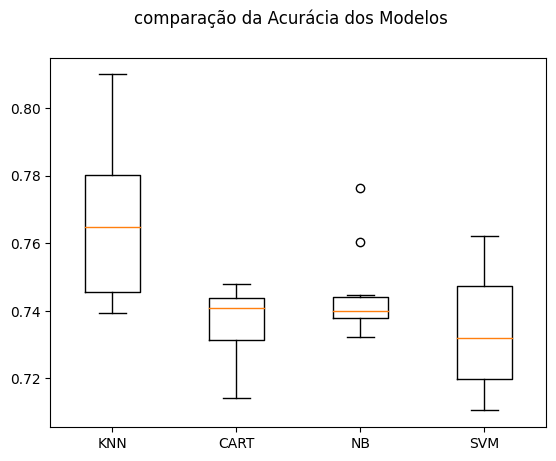

In [ ]:
# Definindo o seed para a célula
seed = 1000
np.random.seed(seed)

# Adicionando as listas para armazenar os modelos, os resultados e os nomes
models = []
results = []
names = []

# Preparando os modelos e adicionando a lista 'models'
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Ajustando o loop 'for' para criar um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=Kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)

  # Verificando a média e o desvio padrão dos 10 resultados da validação cruzada
  msg = '%s: %f (%f)'%(name, cv_results.mean(), cv_results.std())

  print(msg)

# Plotando gráfico de comparação dos modelos
fig = plt.figure()
fig.suptitle('comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

A acuracia do modelo KNN é muito superior as demais, por isso ele será adotado

In [ ]:

# Retreinando o modelo
modelo = KNeighborsClassifier()
modelo.fit(X_train, y_train)

# Calculando as predições
prediction = modelo.predict(X_test)

# Calculando a acurácia
acuracia = accuracy_score(y_test, prediction)

print('A acurácia foi %.2f%%' % (acuracia*100))


A acurácia foi 76.93%


In [ ]:
def retono_predict(predict):
    df_y = []
    df_n = []

    for i in predict:
        if i == 1:
            retorno = 'yes'
            df_y.append(retorno)
        else:
            retorno = 'no'
            df_n.append(retorno)

    churn_y = pd.Series(df_y, name='retorno')
    churn_n = pd.Series(df_n, name='retorno')

    # Criar DataFrames a partir das séries
    df_churn_y = pd.DataFrame(churn_y)
    df_churn_n = pd.DataFrame(churn_n)

    # Unir os dois DataFrames em um único DataFrame
    df_result = pd.concat([df_churn_y, df_churn_n])

    # Resetar os índices do DataFrame resultante
    df_result = df_result.reset_index()

    return df_result

In [ ]:
df_result = retono_predict(prediction)

In [ ]:
df_result

,index,retorno
0,0,yes
1,1,yes
2,2,yes
3,3,yes
4,4,yes
...,...,...
1404,1113,no
1405,1114,no
1406,1115,no
1407,1116,no


In [ ]:
def modelo_KNN(df, data=None, acc=False):
    # Criando copia do df
    data = df.copy()

    # Alterando o valor 'No Internet service' e 'No phone service'
    for col in data.columns:
        if data[col].dtype == 'object':  # Verifica se a coluna contém strings
            data[col] = data[col].str.replace('No phone service', 'No')
            data[col] = data[col].str.replace('No internet service', 'No')

    # Retirando os valores vazios da Churn do conjunto de dados
    data = data.loc[~(data['Churn'] == '')]

    # Alterando os valores vazio da coluna total pela média dos valores
    data['Total'] = np.where(
        data['Total'] == ' ', data['Total'].loc[~(data['Total'] == ' ')].astype(float).mean(), data['Total']
    )

    # Alterando o tipo da coluna total
    data['Total'] = data['Total'].astype(float)

    # Retirando a coluna ID
    data = data.drop('customerID', axis=1)

    #Criando cópia do DataFrame para as novas alterações
    df_premodel = data.copy()

    # Separando as variáveis categoricas
    col_categoricas = df_premodel.select_dtypes(include="object").columns

    # Alterando os valores 'yes' para '1' e 'no' para '0'
    for col in col_categoricas:
        if df_premodel[col].nunique() == 2:
            df_premodel[col] = np.where(data[col] == 'Yes', 1, 0)

    # Aplicando o dummie encondig para as varíaveis categoricas
    col_categoricas = df_premodel.select_dtypes(include='object').columns

    df_model = pd.get_dummies(df_premodel, dtype=int)

    # Criando a variável explicativa
    X = df_model.copy()
    X = X.drop('Churn', axis=1)

    # Ajustando a variável de saída
    y = df_model['Churn']

    # Separando os dados de treino e de teste, será utilizado 80% do dataset para treino e 20% para teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

    # Criando os folds para validação cruzada
    num_particoes = 10

    # Realizando a partição em 10 folds
    Kfold = KFold(n_splits= num_particoes, shuffle = True, random_state=7)

    # treinando o modelo
    modelo = KNeighborsClassifier()
    modelo.fit(X_train, y_train)

    # Calculando as predições
    prediction = modelo.predict(X_test)

    acuracia = accuracy_score(y_test, prediction)

    # Verifica o que foi selecionado em acc
    if acc == False:
      result = prediction
    else:
      result = acuracia

    return result


In [ ]:
df_= modelo_KNN(df)

In [ ]:
df_

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
df_a = modelo_KNN(df, acc=True)

In [ ]:
df_a

0.7693399574166075